# **PROJECT INTRODUCTION**

**AUTHOR** : M. Raihan Rafiiful Allaam (1301164162) - https://alamehan.github.io/


---


**DECRIPTION** : Program ini bertujuan untuk membangun model Convolutional Neural Network (CNN) yang dapat melakukan klasifikasi terhadap 5 genus Anggrek yang umum dibudidayakan, yaitu Cattleya, Dendrobium, Oncidium, Phalaenopsis dan Vanda. Digunakan 2 tipe arsitektur CNN yaitu arsitektur kustom (dirancang manual) dan arsiktektur MobileNetV2. Serta skenario dataset sebagai berikut:<br>
1. Skenario 1 → 4000 data train dengan background noise (800 citra/genus)
2. Skenario 2 → 4000 data train tanpa background noise (800 citra/genus)
3. 2500 data test dari lapangan (500 citra/genus)
4. 185 data test dari internet (25 Cattleya, 40 untuk genus lainnya)


---


**REFERENCE (SOURCE CODE)**:<br>
1. https://datascience.stackexchange.com/questions/48390/how-do-i-build-an-image-dataset-for-cnn
2. https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-fashion-mnist-clothing-classification/
3. https://stackoverflow.com/questions/45969390/difference-between-stratifiedkfold-and-stratifiedshufflesplit-in-sklearn
4. https://www.tensorflow.org/tutorials/images/classification

In [ ]:
# Pakai Tensorflow versi 2.2 agar pada saat model di save nanti, terload dengan baik di flask app python (untuk keperluan deployment)
!pip install tensorflow==2.2  # ⚠️ PENTING ⚠️

     |████████████████████████████████| 516.2MB 35kB/s 
     |████████████████████████████████| 3.0MB 53.4MB/s 
     |████████████████████████████████| 460kB 50.8MB/s 
  Found existing installation: tensorboard 2.4.0
    Uninstalling tensorboard-2.4.0:
      Successfully uninstalled tensorboard-2.4.0
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorflow 2.4.0
    Uninstalling tensorflow-2.4.0:
      Successfully uninstalled tensorflow-2.4.0


In [ ]:
import tensorflow as tf
from tensorflow import keras

# Periksa versi library TensorFlow & Keras
print("Versi TensorFlow :", tf.__version__)
print("Versi Keras      :", keras.__version__)

Versi TensorFlow : 2.2.0
Versi Keras      : 2.3.0-tf


In [ ]:
# Periksa versi library lainnya
!pip list --version

Package                       Version        
----------------------------- ---------------
absl-py                       0.10.0         
alabaster                     0.7.12         
albumentations                0.1.12         
altair                        4.1.0          
argon2-cffi                   20.1.0         
asgiref                       3.3.1          
astor                         0.8.1          
astropy                       4.1            
astunparse                    1.6.3          
async-generator               1.10           
atari-py                      0.2.6          
atomicwrites                  1.4.0          
attrs                         20.3.0         
audioread                     2.1.9          
autograd                      1.3            
Babel                         2.9.0          
backcall                      0.2.0          
beautifulsoup4                4.6.3          
bleach                        3.2.1          
blis                          0.4.

# **1. PRAPROSES DATASET**

**1-1. LOAD DATA DARI GDRIVE/GITHUB**

In [ ]:
# Cara 1 : Load data dari Google Drive
#!unzip /content/drive/MyDrive/Colab\ Notebooks/DATASET/...zip

In [ ]:
# Cara 2 : Load data dari Github
!git clone https://github.com/alamehan/skripsi-cnn-anggrek.git  # ⚠️ SESUAIKAN ⚠️

Cloning into 'skripsi-cnn-anggrek'...
remote: Enumerating objects: 229, done.
remote: Counting objects: 100% (229/229), done.
remote: Compressing objects: 100% (226/226), done.
remote: Total 10819 (delta 3), reused 229 (delta 3), pack-reused 10590
Receiving objects: 100% (10819/10819), 188.35 MiB | 41.96 MiB/s, done.
Resolving deltas: 100% (18/18), done.
Checking out files: 100% (13370/13370), done.


**1-2. UBAH DATA MENJADI ARRAY**

In [ ]:
import os
import cv2
import random
import numpy as np

img_size_150p = 128 # Actually dataset size (Untuk dipakai di Arsitektur CNN Custom)  # ⚠️ SESUAIKAN ⚠️
img_size_224p = 224 # Increase dataset size (untuk dipakai di Arsitektur MobileNetV2) # ⚠️ SESUAIKAN ⚠️

path_train  = '/content/skripsi-cnn-anggrek/dataset/train'                            # ⚠️ SESUAIKAN ⚠️
path_test   = '/content/skripsi-cnn-anggrek/dataset/test'                             # ⚠️ SESUAIKAN ⚠️
path_inet   = '/content/skripsi-cnn-anggrek/dataset/inet'                             # ⚠️ SESUAIKAN ⚠️
categories  = ['cattleya', 'dendrobium', 'oncidium', 'phalaenopsis', 'vanda']         # ⚠️ SESUAIKAN ⚠️

def create_data_img(folder_path):
    imageData = []
    for category in categories:
        path = os.path.join(folder_path, category)
        class_num = categories.index(category) # Ambil label sebagai index (number)
        for img in os.listdir(path):
            img_array   = cv2.imread(os.path.join(path, img)) 
            img_convert = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
            img_resize  = cv2.resize(img_convert, (img_size_224p, img_size_224p))
            imageData.append([img_resize, class_num])
    
    return imageData

dataTrain   = create_data_img(path_train)
dataTest    = create_data_img(path_test)
dataInet    = create_data_img(path_inet)

# Shuffle Data Train (kalo enggak di shuffle, nanti data train ngurut berdasarkan labels)
random.seed(10) # 10 sebagai index shuffle, agar saat run ulang nanti hasil shuffle sama
random.shuffle(dataTrain)

**1-3. GET FEATURES (X) & LABELS (y)**

In [ ]:
# X untuk Features & y untuk labels
X_train, y_train, X_test, y_test, X_inet, y_inet = [], [], [], [], [], []

for features, label in dataTrain:
    X_train.append(features)
    y_train.append(label)

for features, label in dataTest:
    X_test.append(features)
    y_test.append(label)

for features, label in dataInet:
    X_inet.append(features)
    y_inet.append(label)

# -1 di reshape artinya membiarkan numpy menentukan dimensi data yang sesuai
X_train = np.array(X_train).reshape(-1, img_size_224p, img_size_224p, 3)
y_train = np.asarray(y_train)
X_test  = np.array(X_test).reshape(-1, img_size_224p, img_size_224p, 3)
y_test  = np.asarray(y_test)
X_inet  = np.array(X_inet).reshape(-1, img_size_224p, img_size_224p, 3)
y_inet  = np.asarray(y_inet)

print("X_train :", X_train.shape)
print("y_train :", y_train.shape)
print("X_test  :", X_test.shape)
print("y_test  :", y_test.shape)
print("X_inet  :", X_inet.shape)
print("y_inet  :", y_inet.shape)

X_train : (4000, 224, 224, 3)
y_train : (4000,)
X_test  : (2500, 224, 224, 3)
y_test  : (2500,)
X_inet  : (185, 224, 224, 3)
y_inet  : (185,)


In [ ]:
# TIPS : Jika diperlukan gunakan Pickle untuk keperluan save & load variable

# import pickle
# with open('data_simpan.pickle', 'wb') as f:
#   pickle.dump([X_train, y_train, X_test, y_test], f)

# import pickle
# with open('data_simpan.pickle', 'wb') as f:
#   pickle.dump([X_train, y_train, X_test, y_test], f)

**1-4. FEATURES (X) : NORMALIZATION**

In [ ]:
print("Isi Array X_train :\n\n", X_train[0]) # Ambil contoh data pertama
print("\nIsi Array X_test  :\n\n", X_test[0])
print("\nIsi Array X_inet  :\n\n", X_inet[0])

def prep_pixels(train, test, inet):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    inet_norm = inet.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    inet_norm = inet_norm / 255.0
    # return normalized images
    return train_norm, test_norm, inet_norm

X_train_norm, X_test_norm, X_inet_norm = prep_pixels(X_train, X_test, X_inet)

print("\nIsi Array X_train_norm :\n\n", X_train_norm[0])
print("\nIsi Array X_test_norm  :\n\n", X_test_norm[0])
print("\nIsi Array X_inet_norm  :\n\n", X_inet_norm[0])

Isi Array X_train :

 [[[248 254 244]
  [250 255 246]
  [252 255 250]
  ...
  [254 254 254]
  [254 254 254]
  [254 254 254]]

 [[254 255 250]
  [252 255 250]
  [253 255 250]
  ...
  [254 254 254]
  [254 254 254]
  [254 254 254]]

 [[252 252 250]
  [252 254 251]
  [254 254 252]
  ...
  [254 254 254]
  [254 254 254]
  [254 254 254]]

 ...

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [254 254 254]
  [254 254 254]
  [254 254 254]]

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [254 254 254]
  [254 254 254]
  [254 254 254]]

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [254 254 254]
  [254 254 254]
  [254 254 254]]]

Isi Array X_test  :

 [[[175 192 137]
  [156 173 119]
  [119 132  88]
  ...
  [180 206 143]
  [153 176 122]
  [128 150 101]]

 [[163 180 126]
  [187 204 152]
  [151 164 120]
  ...
  [170 196 131]
  [156 180 122]
  [152 175 119]]

 [[129 143  92]
  [137 151 102]
  [168 181 137]
  ...
  [161 187 116]
  [162 184 119]
  [141 163  98]]

 ...

 [[ 28 

**1-5. LABELS (y) : ONE HOT ENCODING**

In [ ]:
from keras.utils import to_categorical

print("Isi Array y_train :", y_train)
print("Isi Array y_test  :", y_test)
print("Isi Array y_inet  :", y_inet)

# one hot encode target values
y_train_encode = to_categorical(y_train)
y_test_encode  = to_categorical(y_test)
y_inet_encode  = to_categorical(y_inet)

print("\nIsi Array y_train_encode :\n\n", y_train_encode)
print("\nIsi Array y_test_encode :\n\n", y_test_encode)
print("\nIsi Array y_inet_encode :\n\n", y_inet_encode)

Isi Array y_train : [3 2 4 ... 2 0 2]
Isi Array y_test  : [0 0 0 ... 4 4 4]
Isi Array y_inet  : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]

Isi Array y_train_encode :

 [[0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 ...
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]

Isi Array y_test_encode :

 [[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]

Isi Array y_inet_encode :

 [[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 

**1-5. PLOT/TAMPILKAN DATASET**

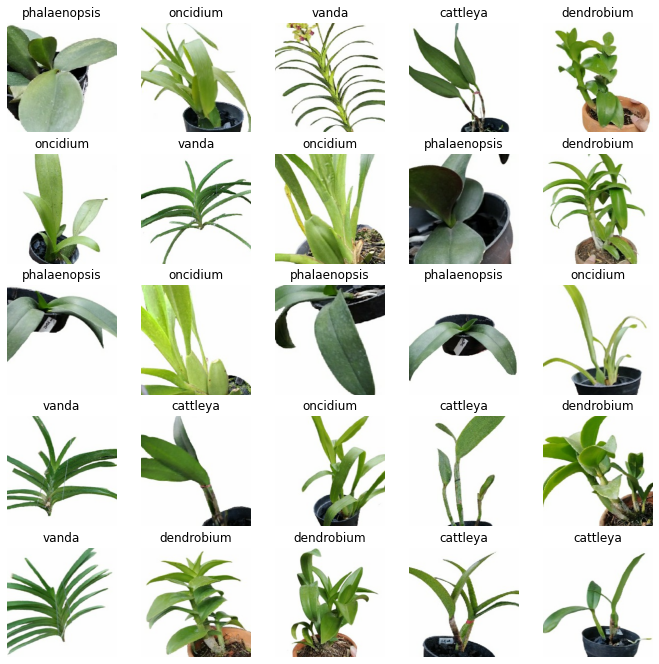

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

nrows = 5     # ⚠️ SESUAIKAN ⚠️
ncols = 5     # ⚠️ SESUAIKAN ⚠️
hspace = 0
wspace = 0
fig, ax = plt.subplots(nrows, ncols, figsize=(10, 10))    
fig.subplots_adjust(hspace, wspace)

for i in range(nrows):
    for j in range(ncols):
        temp = i*ncols+j                # Index looping
        ax[i,j].imshow(X_train[temp])   # Show features/images
        if y_train[temp] == 0:          # ⚠️ SESUAIKAN ⚠️
            judul = "cattleya"          # ⚠️ SESUAIKAN ⚠️
        elif y_train[temp] == 1:        # ⚠️ SESUAIKAN ⚠️
            judul = "dendrobium"        # ⚠️ SESUAIKAN ⚠️
        elif y_train[temp] == 2:        # ⚠️ SESUAIKAN ⚠️
            judul = "oncidium"          # ⚠️ SESUAIKAN ⚠️
        elif y_train[temp] == 3:        # ⚠️ SESUAIKAN ⚠️
            judul = "phalaenopsis"      # ⚠️ SESUAIKAN ⚠️
        elif y_train[temp] == 4:        # ⚠️ SESUAIKAN ⚠️
            judul = "vanda"             # ⚠️ SESUAIKAN ⚠️
        ax[i,j].set_title(judul)        # Show labels
        ax[i,j].axis('off')             # Hide axis
plt.show()

**1-6. BERSIHKAN USELESS DATA (RAM CLEANER)**

In [ ]:
import gc     # Gabage collector for cleaning deleted data from memory (in case : Clear list that are useless)

del dataTrain
del dataTest
del dataInet
del X_train
del X_test
del X_inet
#del y_train  # Dipakai nanti untuk confusion Matrix
#del y_test   # Dipakai nanti untuk confusion Matrix
#del y_inet   # Dipakai nanti untuk confusion Matrix

gc.collect()

43

**1-7. DATA FINAL YANG AKAN DIGUNAKAN**

In [ ]:
print("X_train_norm     :", X_train_norm.shape)
print("y_train_encode   :", y_train_encode.shape)
print("X_test_norm      :", X_test_norm.shape)
print("y_test_encode    :", y_test_encode.shape)
print("X_inet_norm      :", X_inet_norm.shape)
print("y_inet_encode    :", y_inet_encode.shape)

X_train_norm     : (4000, 224, 224, 3)
y_train_encode   : (4000, 5)
X_test_norm      : (2500, 224, 224, 3)
y_test_encode    : (2500, 5)
X_inet_norm      : (185, 224, 224, 3)
y_inet_encode    : (185, 5)


# **2. BANGUN ARSITEKTUR**

**2-1. ARSITEKTUR MOBILENETV2**

9412608/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
________________

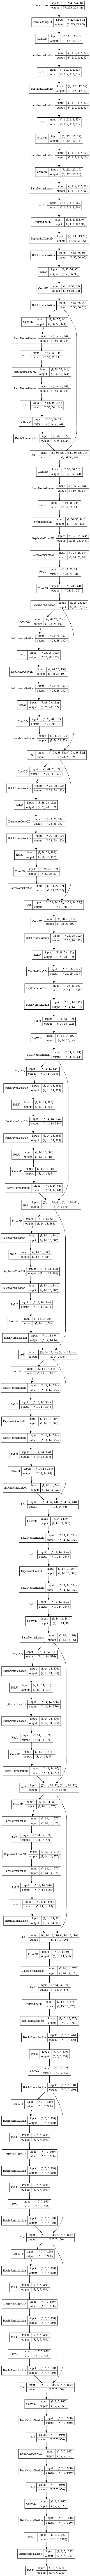

In [ ]:
from keras.applications import MobileNetV2
from keras.utils import plot_model

'''
> weights='imagenet'            bobot diawal diisi langsung dengan bobotnya "cerdas"nya imagenet (pre-trained), jumlah epoch bisa sedikit
> weights=None                  bobot diawal diisi dengan nilai secara acak (random), jika menggunakan ini perbanyak jumlah epoch
> include_top=False             tidak mengikutsertakan fully-connected layer (karena akan didefinisikan secara terpisah dan menyesuaikan
                                dengan dataset yang dipakai), dengan kata lain yang diambil hanya feature extractor layernya saja
> conv_base.trainable=False     hanya diaktifkan jika weights='imagenet', artinya bobot di feature extractor tidak akan diperbarui saat
                                training (freeze), dengan kata lain "proses belajar" hanya akan dilakukan di fully-connected layer yang
                                telah didefinisikan sebelumnya secara terpisah. (feature extractor hanya tinggal dipakai saja)
'''

conv_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size_224p, img_size_224p, 3)) # ⚠️ SESUAIKAN ⚠️
conv_base.trainable = False                                                                                   # ⚠️ SESUAIKAN ⚠️
conv_base.summary()
plot_model(conv_base, to_file='model.png', show_shapes=True, show_layer_names=False, rankdir='TB', expand_nested=False, dpi=80)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


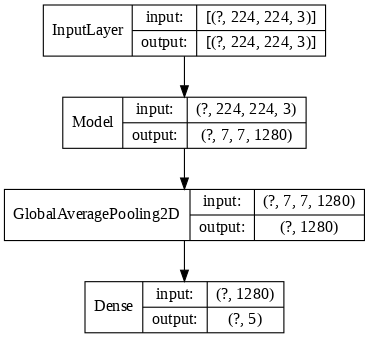

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras.optimizers import Adam

def define_model_mobilenetv2():
    model = Sequential()
    
    # 01-Feature Extractor Layer
    model.add(conv_base)                        # Feature Extractor pakai pre-trained model
    model.add(GlobalAveragePooling2D())
    
    # 02-Flatten Layer
    #model.add(Flatten())
    
    # 03-Fully Connected Layer
    #model.add(Dense(128, activation='relu'))    # ⚠️ SESUAIKAN ⚠️
    #model.add(Dropout(0.5, seed=10))            # ⚠️ SESUAIKAN ⚠️ (Coba pakai seed=0 atau 1,2,3,...)
    #model.add(Dense(64, activation='relu'))     # ⚠️ SESUAIKAN ⚠️
    #model.add(Dropout(0.5, seed=10))            # ⚠️ SESUAIKAN ⚠️ (Coba pakai seed=0 atau 1,2,3,...)
    model.add(Dense(5, activation='softmax'))   # ⚠️ SESUAIKAN ⚠️
    
    # Compile Model
    opt = Adam(lr=0.0003)                       # ⚠️ SESUAIKAN ⚠️
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy']) # ⚠️ SESUAIKAN ⚠️
    return model

# Bersihkan model sebelumnya (keperluan re-training)
if "model" in globals(): # Check jika apakah variable model ada?
  del model
  gc.collect()

model = define_model_mobilenetv2()
model.summary()
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False, rankdir='TB', expand_nested=False, dpi=80)

**2-2. ARSITEKTUR KUSTOM**

In [ ]:
# Referensi Arsitektur: https://www.tensorflow.org/tutorials/images/classification

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.utils import plot_model

def define_model_kustom():
    model = Sequential()

    # 01-Feature Extractor Layer
    model.add(Conv2D(32, (5, 5), activation='relu', padding='same', input_shape=(img_size_224p, img_size_224p, 3))) # ⚠️ Sesuaikan Input Shape
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (5, 5), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # 02-Flatten Layer
    model.add(Flatten())
    
    # 03-Fully Connected Layer
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5, seed=10))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5, seed=10))
    model.add(Dense(5, activation='softmax'))
    
    # Compile Model
    opt = Adam(lr=0.0003)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = define_model_kustom()
model.summary()
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False, rankdir='TB', expand_nested=False, dpi=80) # TB (Top Bottom) / LR (Left Right)

# **3A. TRAINING DENGAN K-FOLD**

**3-1. TRAINING UNTUK 5 FOLDS**

In [ ]:
os.mkdir("/content/simpan_model") # Buat folder untuk save model report (run 1x)

In [ ]:
%%time

import pandas as pd
from sklearn.model_selection import KFold, StratifiedKFold, StratifiedShuffleSplit

def evaluate_model(dataX, dataY, n_folds=5):  # ⚠️ SESUAIKAN ⚠️ (Hanya Data Train yang digunakan, nanti dipecah jadi Train & Validasi oleh library)
    epochs = 10                               # ⚠️ SESUAIKAN ⚠️
    batch_size = 64                           # ⚠️ SESUAIKAN ⚠️

    scores, histories = list(), list()
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1) # ⚠️ SESUAIKAN ⚠️ (1 sebagai seed/index shuffle, agar saat run ulang nanti hasil shuffle sama)

    i = 0
    # enumerate splits
    for train_ix, val_ix in kfold.split(dataX):
        i = i+1
        # define model
        model = define_model_mobilenetv2()    # ⚠️ SESUAIKAN ⚠️
        # select rows for train and test
        trainX, trainY, valX, valY = dataX[train_ix], dataY[train_ix], dataX[val_ix], dataY[val_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, validation_data=(valX, valY), verbose=1)
        # evaluate model
        loss, acc = model.evaluate(valX, valY, verbose=0)
        print('\nAkurasi Fold ke-' + str(i) + ' = %.3f' % (acc * 100.0))
        print('Loss Fold ke-' + str(i) + ' = %.3f' % (loss) + '\n')
        # append scores
        scores.append(acc)
        histories.append(history)

        #----------------------------- Additional -----------------------------#

        # 01 - Save model as h5
        model.save("/content/simpan_model/model_fold_" + str(i) + ".h5")

        # 02 - Save model report to csv
        model_csv = pd.DataFrame(history.history)
        csv_file = "/content/simpan_model/model_fold_" + str(i) + ".csv"
        with open(csv_file, mode="w") as f:
          model_csv.to_csv(f)
        
        # 03 - Clean the RAM for every Fold
        del trainX
        del trainY
        del valX
        del valY
        del model
        gc.collect()

        #----------------------------------------------------------------------#

    return scores, histories
    
scores, histories = evaluate_model(X_train_norm, y_train_encode)

Epoch 1/10
50/50 [==============================] - 6s 118ms/step - loss: 1.1026 - accuracy: 0.6009 - val_loss: 0.6272 - val_accuracy: 0.8375
Epoch 2/10
50/50 [==============================] - 5s 94ms/step - loss: 0.4444 - accuracy: 0.9153 - val_loss: 0.3358 - val_accuracy: 0.9388
Epoch 3/10
50/50 [==============================] - 5s 95ms/step - loss: 0.2690 - accuracy: 0.9622 - val_loss: 0.2296 - val_accuracy: 0.9650
Epoch 4/10
50/50 [==============================] - 5s 94ms/step - loss: 0.1910 - accuracy: 0.9775 - val_loss: 0.1729 - val_accuracy: 0.9737
Epoch 5/10
50/50 [==============================] - 5s 95ms/step - loss: 0.1468 - accuracy: 0.9834 - val_loss: 0.1377 - val_accuracy: 0.9800
Epoch 6/10
50/50 [==============================] - 5s 94ms/step - loss: 0.1191 - accuracy: 0.9872 - val_loss: 0.1152 - val_accuracy: 0.9837
Epoch 7/10
50/50 [==============================] - 5s 94ms/step - loss: 0.0985 - accuracy: 0.9912 - val_loss: 0.0962 - val_accuracy: 0.9887
Epoch 8/10
5

**3-2. OPTION 1 : PLOT GRAFIK HASIL TRAINING COMBINE**

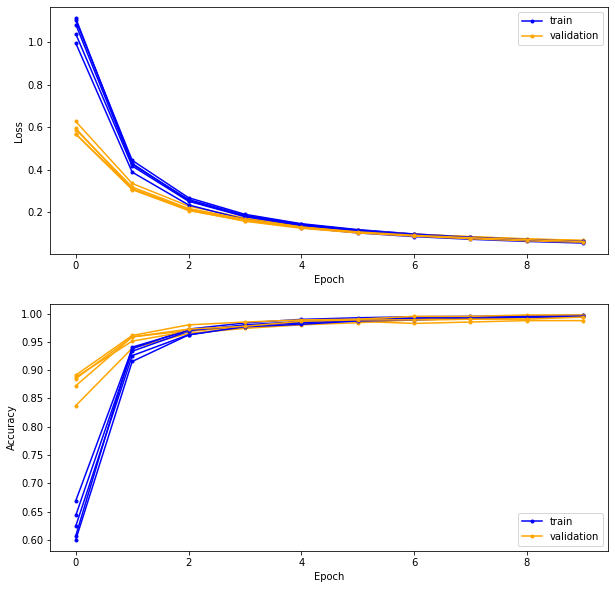

In [ ]:
import warnings
warnings.filterwarnings('ignore')

def summarize_diagnostics_combine(histories):
    plt.figure(figsize=(10,10))
    
    for i in range(len(histories)):
        # plot loss
        plt.subplot(211) # 2 baris, 1 kolom, index ke-1
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.plot(histories[i].history['loss'], color='blue', marker='.', label='train')
        plt.plot(histories[i].history['val_loss'], color='orange', marker='.', label='test')
        plt.legend(['train', 'validation'], loc='upper right')
        
        # plot accuracy
        plt.subplot(212) # 2 baris, 1 kolom, index ke-2
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.plot(histories[i].history['accuracy'], color='blue', marker='.', label='train')
        plt.plot(histories[i].history['val_accuracy'], color='orange', marker='.', label='test')
        plt.legend(['train', 'validation'], loc='bottom right')
    plt.show()

summarize_diagnostics_combine(histories)

**3-2. OPTION 2 : PLOT GRAFIK HASIL TRAINING SINGLE**

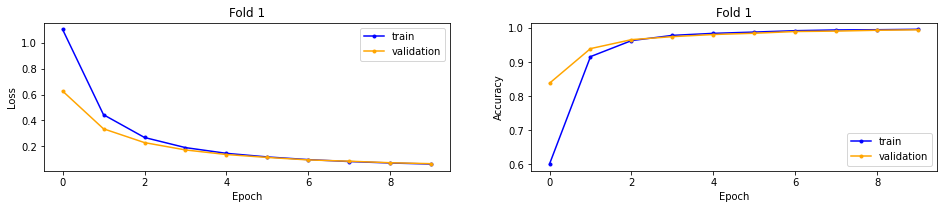

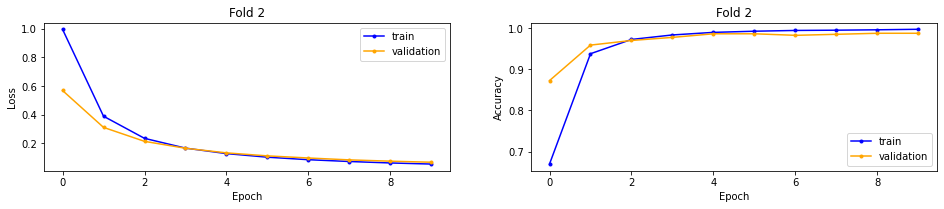

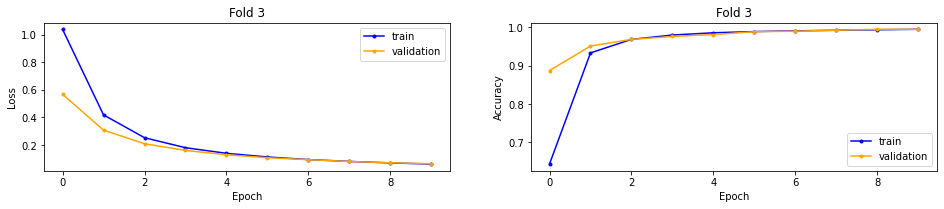

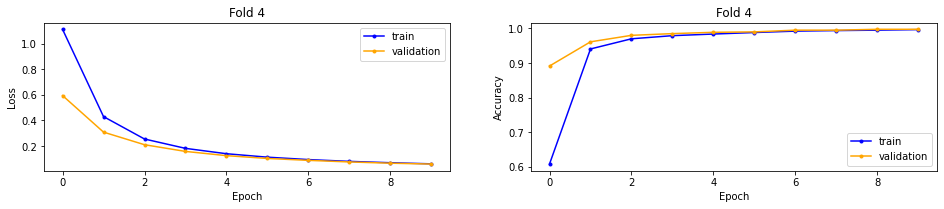

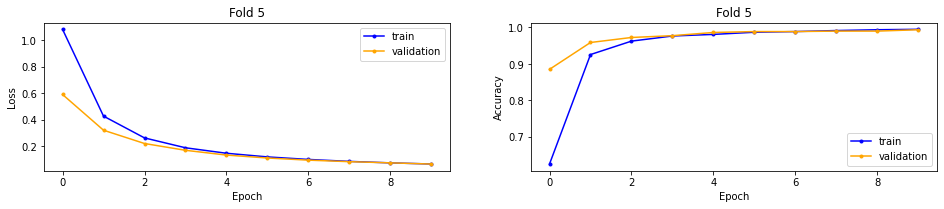

In [ ]:
import warnings
warnings.filterwarnings('ignore')

def summarize_diagnostics_single(histories):
    for i in range(len(histories)):
        plt.figure(figsize=(16,6))

        # plot loss
        plt.subplot(221) # 2 baris, 2 kolom, index ke-1
        plt.title('Fold ' + str(i+1))
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.plot(histories[i].history['loss'], color='blue', marker='.', label='train')
        plt.plot(histories[i].history['val_loss'], color='orange', marker='.', label='test')
        plt.legend(['train', 'validation'], loc='upper right')

        # plot accuracy
        plt.subplot(222) # 2 baris, 2 kolom, index ke-2
        plt.title('Fold ' + str(i+1))
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.plot(histories[i].history['accuracy'], color='blue', marker='.', label='train')
        plt.plot(histories[i].history['val_accuracy'], color='orange', marker='.', label='test')
        plt.legend(['train', 'validation'], loc='bottom right')
        plt.show()

summarize_diagnostics_single(histories)

**3-3. PLOT SKOR AKHIR (MEAN & STD)**

Accuracy: mean=99.350 std=0.330, n=5


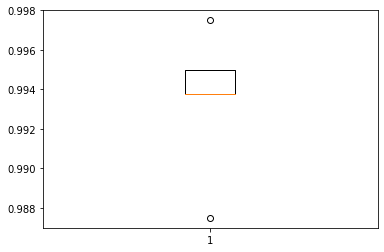

In [ ]:
from numpy import mean
from numpy import std

def summarize_performance(scores):
    # print summary
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
    # box and whisker plots of results
    plt.boxplot(scores)
    plt.show()

# summarize estimated performance
summarize_performance(scores)

# **3B. TRAINING TANPA K-FOLD**

In [ ]:
os.mkdir("/content/simpan_model") # Buat folder untuk save model report (run 1x)

In [ ]:
%%time

import pandas as pd

epochs = 10       # ⚠️ SESUAIKAN ⚠️
batch_size = 64   # ⚠️ SESUAIKAN ⚠️

model = define_model_mobilenetv2() 

#=======================================================================================================================================#
# CARA 1 : validation_split=0.2 ➜ artinya langsung memecah data train ➜ jadi 80% train & 20% validation ➜ memakan banyak sekali RAM
#          hal ini berarti pula bahwa penggunaan K-Fold itu memberatkan komputasi, coba saja sendiri, terlebih jika data berupa image
#          dan jumlah data hingga ribuan, hal ini akan memakan bayak sekali RAM, bahkan bisa hingga terjadi Out of Memory (OOM). Dan
#          karena alasan ini pula banyak sekali tutorial Image Classification dengan CNN yang tersebar di internet, tidak memakai
#          K-Fold. sebenarnya penggunaan K-Fold itu diperuntukan untuk Machine Learning, bukan Deep Learning, karena alasan komputasi.
#          sebagai alternatif solusinya yaitu gunakan saja pre-trained model terkenal, maka K-Fold tidak terlalu dibutuhkan, bahkan
#          jumlah epoch pun tidak harus banyak. dengan pre-trained model terkenal, meskipun dataset yang digunakan sedikit (misal
#          dibawah 1000), tetap berpotensi besar menghasilkan model yang optimal untuk kasus dataset yang digunakan. dan jika pada
#          saat testing menghasilkan akurasi yang baik, maka hal ini sudah membuktikan bahwa penggunaan K-Fold tidak terlalu dibutuhkan.
#=======================================================================================================================================#
#history = model.fit(X_train_norm, y_train_encode, validation_split=0.2, epochs=20, batch_size=32, verbose=1)

#=======================================================================================================================================#
# CARA 2 : validation_data=(X_test_norm, y_test_encode) ➜ artinya gunakan data validasi dari luar/bukan dari data train yang dipecah
#          ➜ minim penggunaan RAM. CARA 2 ini sebagai alternatif solusi yang baik jika ingin training dengan validasi sekaligus.
#=======================================================================================================================================#
#history = model.fit(X_train_norm, y_train_encode, validation_data=(X_test_norm, y_test_encode), epochs=20, batch_size=32, verbose=1)

#=======================================================================================================================================#
# CARA 3 : TANPA VALIDATION DATA. jika menggunakan CARA 2, malah menghasilkan lebih banyak salah prediksi saat testing data dari internet.
#          hal ini kemungkinan besar akibat terlalu serupanya data train dengan data validasi. Oleh karena itu, dalam kasus ini, karena
#          memang dataset yang sebenarnya hanya sedikit (banyak akibat di augmetasi saja), maka yang dilakukan hanyalah training dan
#          testing saja, tanpa melalui tahapan validasi. namun disamping itu, model yang dihasilkan sudah cukup baik. buktikan saja.
#=======================================================================================================================================#
history = model.fit(X_train_norm, y_train_encode, epochs=epochs, batch_size=batch_size, verbose=1)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.plot(history.history['accuracy'], 'og', linestyle='dashed')
#ax.plot(history.history['val_accuracy'])
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
#ax.legend(['train', 'val'], loc='lower right')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.plot(history.history['loss'], 'ob', linestyle='dashed')
#ax.plot(history.history['val_loss'])
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
#ax.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
# 01 - Save model as h5
model.save("/content/simpan_model/model_tanpa_kfold.h5")

# 02 - Save model report to csv
model_csv = pd.DataFrame(history.history)
csv_file = "/content/simpan_model/model_tanpa_kfold.csv"
with open(csv_file, mode="w") as f:
  model_csv.to_csv(f)

# **4. TESTING MODEL (EVALUASI)**

**4-1. LOAD MODEL YANG DIPILIH**

In [ ]:
# Bersihkan model sebelumnya (RAM cleaner)
if "model" in globals():
  del model
  gc.collect()

# Load model
from keras.models import load_model
# Masukkan path model yang dipilih
model = load_model('/content/simpan_model/model_fold_5.h5') # ⚠️ SESUAIKAN ⚠️
#model.summary()

**4-2. OPTION 1 : TESTING MODEL DENGAN DATA TEST LAPANGAN**

In [ ]:
from sklearn.preprocessing import LabelBinarizer

# RAM cleaner
if "encoder" in globals():
  del encoder
  del y_train_encode_new
  del y_test_encode_new
  del y_inet_encode_new
  del pred
  del prediksi
  del pred_label
  del true_label
  gc.collect()

# Encoding Labels (y) dengan cara yang berbeda, untuk keperluan confusion matrix
encoder             = LabelBinarizer()
y_train_encode_new  = encoder.fit_transform(y_train)
y_test_encode_new   = encoder.fit_transform(y_test)
y_inet_encode_new   = encoder.fit_transform(y_inet)

# ============================================================================ #
# =============================== DATA TESTING =============================== #
# ============================================================================ #

pred        = model.predict(X_test_norm.astype('float32'), verbose=0)
prediksi    = np.argmax(pred, axis=-1) # coba -> predict.shape -> (800, 5) -> maka axis=-1 itu akan ngambil nilai 5 tersebut (yaitu kategori/labelnya)

'''
Please use instead:
* np.argmax(model.predict(x), axis=-1)      if your model does multi-class classification (e.g. if it uses a `softmax` last-layer activation).
* (model.predict(x) > 0.5).astype("int32")  if your model does binary classification (e.g. if it uses a `sigmoid` last-layer activation).
'''

pred_label  = model.predict_classes(X_test_norm, batch_size=64, verbose=0)  # label hasil prediksi
true_label  = np.argmax(y_test_encode_new, axis=-1)                         # label yang sebenarnya

print("Label Prediksi   :", pred_label)
print("Label Sebenarya  :", true_label, "\n")
loss, acc = model.evaluate(X_test_norm, y_test_encode_new, verbose=1)

Label Prediksi   : [2 0 0 ... 4 4 4]
Label Sebenarya  : [0 0 0 ... 4 4 4] 

79/79 [==============================] - 3s 40ms/step - loss: 0.4594 - accuracy: 0.8312


**4-2. OPTION 2 : TESTING MODEL DENGAN DATA TEST INTERNET**

In [ ]:
from sklearn.preprocessing import LabelBinarizer

# RAM cleaner
if "encoder" in globals():
  del encoder
  del y_train_encode_new
  del y_test_encode_new
  del y_inet_encode_new
  del pred
  del prediksi
  del pred_label
  del true_label
  gc.collect()

# Encoding Labels (y) dengan cara yang berbeda, untuk keperluan confusion matrix
encoder             = LabelBinarizer()
y_train_encode_new  = encoder.fit_transform(y_train)
y_test_encode_new   = encoder.fit_transform(y_test)
y_inet_encode_new   = encoder.fit_transform(y_inet)

# ============================================================================ #
# ============================== DATA INTERNET =============================== #
# ============================================================================ #

pred        = model.predict(X_inet_norm.astype('float32'), verbose=0)
prediksi    = np.argmax(pred, axis=-1)

pred_label  = model.predict_classes(X_inet_norm, batch_size=64, verbose=0)  # label hasil prediksi
true_label  = np.argmax(y_inet_encode_new, axis=-1)                         # label yang sebenarnya

print("Label Prediksi   :", pred_label)
print("Label Sebenarya  :", true_label, "\n")
loss, acc = model.evaluate(X_inet_norm, y_inet_encode_new, verbose=1)

Label Prediksi   : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 2 0 2 2 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 2 2 1 1 1 1 0 1 1 4 1 1 1 1 1 3 1 2 2 1 1 1 1 1 4 2 0 2 2 2 2 0 2
 2 0 2 2 0 0 0 2 1 4 2 2 1 0 2 2 1 2 2 4 2 2 2 2 2 0 2 0 2 2 2 3 3 3 3 3 3
 3 3 3 3 1 3 3 3 1 2 3 1 3 3 1 3 3 1 0 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 4 4 4 4 4 4 4 4 4 4 4 4 1]
Label Sebenarya  : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4] 

6/6 [==============================] - 0s 31ms/step - loss: 0.6464 - accuracy: 0.8000


**4-3. CONFUSION MATRIX & CLASSIFICATION REPORT**

Accuracy : 83.120%
Loss     : 0.459

Classification Report :

              precision    recall  f1-score   support

    cattleya       0.98      0.71      0.82       500
  dendrobium       0.74      0.99      0.84       500
    oncidium       0.71      0.85      0.77       500
phalaenopsis       0.88      0.92      0.90       500
       vanda       0.99      0.69      0.81       500

    accuracy                           0.83      2500
   macro avg       0.86      0.83      0.83      2500
weighted avg       0.86      0.83      0.83      2500



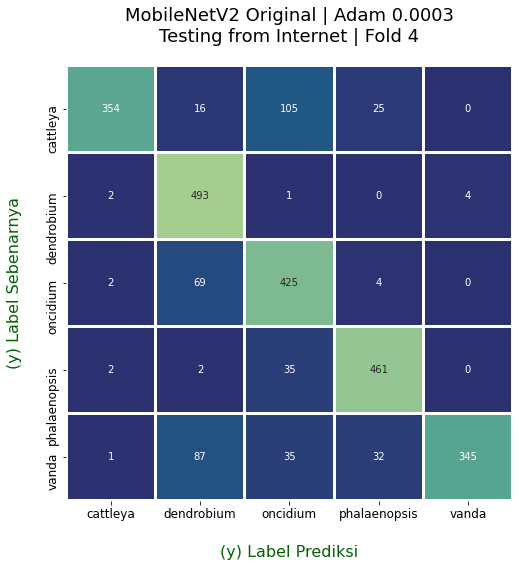

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

target_names = ['cattleya', 'dendrobium', 'oncidium', 'phalaenopsis', 'vanda']  # ⚠️ SESUAIKAN ⚠️
cmatrix = confusion_matrix(true_label, pred_label)
creport = classification_report(true_label, prediksi, target_names=target_names)

print("Accuracy : {:.3f}%".format(acc*100))
print("Loss     : {:.3f}".format(loss))

print("\nClassification Report :\n")
print(creport)

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cmatrix, cmap="crest_r", annot=True, fmt='.4g', linewidths=2, linecolor='white', cbar=False, ax=ax)
# cmap options: rocket, mako, flare, crest, magma, viridis, rocket_r, cubehelix, seagreen, Blues, ...

ax.set_title('MobileNetV2 Original | Adam 0.0003\nTesting from Internet | Fold 4', fontsize=18, pad=24)  # ⚠️ SESUAIKAN ⚠️ fontsize=14, pad=24)  # ⚠️ SESUAIKAN ⚠️
ax.set_xticklabels(labels=target_names, fontsize=12)
ax.set_yticklabels(labels=target_names, fontsize=12)

plt.xlabel("(y) Label Prediksi", fontsize=16, color="darkgreen", labelpad=24)
plt.ylabel("(y) Label Sebenarnya", fontsize=16, color="darkgreen", labelpad=24)
plt.show()

**4-4. BACKUP MODEL PILIHAN KE GOOGLE DRIVE**

In [ ]:
import pandas as pd

# 01 - Save model as h5
model.save('mobilenetv2_original_adam_00003_fold_5.h5') # ⚠️ SESUAIKAN ⚠️

# 02 - Save model report to csv
# model_csv = pd.DataFrame(history.history)
# csv_file = "final_model.csv"
# with open(csv_file, mode="w") as f:
#   model_csv.to_csv(f)

In [ ]:
# Mount to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp mobilenetv2_original_adam_00003_fold_5.h5 "drive/My Drive/"
#!cp final_model.csv "drive/My Drive/"

# **5. TEST PER 1 IMAGE BARU**

**5-1. UPLOAD DATA BARU**

In [ ]:
# Cara 1 : Langsung pakai dari "/content/skripsi-cnn/test-from-internet" (data dari github) # ⚠️ YANG DIPAKAI DALAM KASUS INI ⚠️

In [ ]:
# Cara 2 : Upload data baru via local PC
from google.colab import files
uploaded = files.upload()

In [ ]:
# Cara 3 : Upload data baru via download langsung dari internet
!wget -O 'data_test_baru.jpg' 'https://lumencms.blob.core.windows.net/media-generated/538/_L2A0849-ANSU-VANDA-Vanda-Terra-2-600-600.jpg'

**5-2. BUAT PREDIKSI**

In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model

# load and prepare the image
def load_image(filename):
    img = load_img(filename, target_size=(img_size_224p, img_size_224p))
    plt.imshow(img)
    plt.axis("off");
    img = img_to_array(img)
    img = img.reshape(-1, img_size_224p, img_size_224p, 3)
    img = img.astype('float32')
    img = img / 255.0
    return img

# load an image and predict the class
def run_example(new_data_path):
    # load the image
    img = load_image(new_data_path)
    # load model
    model = load_model('/content/mobilenetv2_original_adam_00003_fold_5.h5')    # ⚠️ SESUAIKAN ⚠️
    # predict the class
    result = model.predict_classes(img)               # ⚠️ OPTION 1 ⚠️ (Hasilnya berbeda dengan OPTION 2, WHY?)
    #result = model.predict(img)                      # ⚠️ OPTION 2 ⚠️ (Hasilnya berbeda dengan OPTION 1, WHY?)
    if result[0] == 0:                                # ⚠️ SESUAIKAN ⚠️
        print("\nHasil Prediksi: Cattleya")           # ⚠️ SESUAIKAN ⚠️
    elif result[0] == 1:                              # ⚠️ SESUAIKAN ⚠️
        print("\nHasil Prediksi: Dendrobium")         # ⚠️ SESUAIKAN ⚠️
    elif result[0] == 2:                              # ⚠️ SESUAIKAN ⚠️
        print("\nHasil Prediksi: Oncidium")           # ⚠️ SESUAIKAN ⚠️
    elif result[0] == 3:                              # ⚠️ SESUAIKAN ⚠️
        print("\nHasil Prediksi: Phalaenopsis")       # ⚠️ SESUAIKAN ⚠️
    elif result[0] == 4:                              # ⚠️ SESUAIKAN ⚠️
        print("\nHasil Prediksi: Vanda")              # ⚠️ SESUAIKAN ⚠️


Hasil Prediksi: Vanda


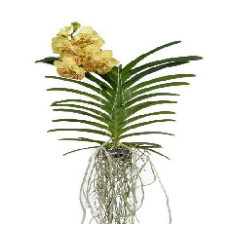

In [ ]:
new_data_path = '/content/skripsi-cnn-anggrek/dataset/inet/vanda/V1.jpg'  # ⚠️ SESUAIKAN ⚠️
run_example(new_data_path)